In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setup

In [2]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00
time: 281 µs (started: 2023-08-15 00:57:26 +00:00)


In [3]:
%cd /content/drive/MyDrive/AIC_2023/BLIP/BLIP

!pip3 install transformers==4.25.1 timm==0.4.12 fairscale==0.4.4
!pip install faiss-gpu
!pip install ftfy regex tqdm
!pip install translate
!pip install googletrans==3.1.0a0
!pip install langdetect

/content/drive/MyDrive/AIC_2023/BLIP/BLIP
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.3 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292831 sha256=c6c097993dd9629fdf411d5e5affb2ab70dd3e8a5a1d47558702b9f4a1e7af0a
  Stored in directory: /root/.cache/pip/wheels/08/58/6f/56c57fa8315eb0bcf0287b580c850845be5f116359b809e9f1
Successfully built fairscale
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 2.8 MB/s eta 0:00:00
     ━

### Extractor feature

In [22]:
from transformers import BertTokenizer
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
import requests
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.med import BertConfig, BertModel
from models.blip import create_vit, init_tokenizer, load_checkpoint


class My_BLIP(nn.Module):
    def __init__(self,
                 med_config = 'configs/med_config.json',
                 image_size = 384,
                 vit = 'base',
                 vit_grad_ckpt = False,
                 vit_ckpt_layer = 0,
                 embed_dim = 256,
                 ):
        """
        Args:
            med_config (str): path for the mixture of encoder-decoder model's configuration file
            image_size (int): input image size
            vit (str): model size of vision transformer
        """
        super().__init__()

        self.visual_encoder, vision_width = create_vit(vit,image_size, vit_grad_ckpt, vit_ckpt_layer)
        self.tokenizer = init_tokenizer()
        med_config = BertConfig.from_json_file(med_config)
        med_config.encoder_width = vision_width
        self.text_encoder = BertModel(config=med_config, add_pooling_layer=False)

        text_width = self.text_encoder.config.hidden_size

        self.vision_proj = nn.Linear(vision_width, embed_dim)
        self.text_proj = nn.Linear(text_width, embed_dim)
        self.vision_width = vision_width
        self.text_width = text_width
        self.itm_head = nn.Linear(text_width, 2)


    def forward(self, image, caption, match_head='itm'):

        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        text = self.tokenizer(caption, padding='max_length', truncation=True, max_length=35,
                              return_tensors="pt").to(image.device)


        if match_head=='itm':
            output = self.text_encoder(text.input_ids,
                                       attention_mask = text.attention_mask,
                                       encoder_hidden_states = image_embeds,
                                       encoder_attention_mask = image_atts,
                                       return_dict = True,
                                      )
            itm_output = self.itm_head(output.last_hidden_state[:,0,:])
            return itm_output

        elif match_head=='itc':
            text_output = self.text_encoder(text.input_ids, attention_mask = text.attention_mask,
                                            return_dict = True, mode = 'text')
            image_feat = F.normalize(self.vision_proj(image_embeds[:,0,:]),dim=-1)
            text_feat = F.normalize(self.text_proj(text_output.last_hidden_state[:,0,:]),dim=-1)

            sim = image_feat @ text_feat.t()
            return sim
    #get features and matching
    def get_text_features(self, caption, device):
        text = self.tokenizer(caption, padding='max_length', truncation=True, max_length=35,
                              return_tensors="pt").to(device)
        text_output = self.text_encoder(text.input_ids, attention_mask = text.attention_mask,
                                            return_dict = True, mode = 'text')
        # print(text_output.last_hidden_state.shape)
        text_feat = F.normalize(self.text_proj(text_output.last_hidden_state[:,0,:]),dim=-1)
        return text_feat
    def get_image_features(self, image):
        image_embeds = self.visual_encoder(image)
        # print(image_embeds.shape)
        image_feat = F.normalize(self.vision_proj(image_embeds[:,0,:]),dim=-1)
        return image_feat

    def get_fts_img(self, image):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)
        return image_embeds
    def matching(self, caption, image_embeds, image_atts, device):
        text = self.tokenizer(caption, padding='max_length', truncation=True, max_length=35,
                                return_tensors="pt").to(device)
        output = self.text_encoder(text.input_ids,
                                        attention_mask = text.attention_mask,
                                        encoder_hidden_states = image_embeds,
                                        encoder_attention_mask = image_atts,
                                        return_dict = True,
                                        )
        itm_output = self.itm_head(output.last_hidden_state[:,0,:])
        print('test', output.last_hidden_state[:,0,:])
        print('shape', output.last_hidden_state[:,0,:].shape)
        return itm_output


def my_blip_itm(pretrained='',**kwargs):
    model = My_BLIP(**kwargs)
    if pretrained:
        model,msg = load_checkpoint(model,pretrained)
        assert(len(msg.missing_keys)==0)
    return model
def load_image(image_path, image_size, show_image=False, device='cuda'):
    image = Image.open(image_path)
    if show_image:
        image.resize((image_size,image_size)).show()
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(image).unsqueeze(0).to(device)
    return image

time: 3.88 ms (started: 2023-08-15 01:31:10 +00:00)


In [20]:
import glob

##### Load Model #####
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 224
model = my_blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device=device)

################# Config Folder #################
features_path = '/content/drive/MyDrive/AIC_2023/Faiss/feature'
keyframes_path = '/content/drive/MyDrive/AIC_2023/Faiss/keyframes'
#################################################

video_paths = sorted(glob.glob(f"{keyframes_path}/*/*"))


for vd_path in video_paths:
  print(vd_path)

  re_feats = []
  keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
  keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

  for keyframe_path in keyframe_paths:


    image = load_image(image_path=keyframe_path, image_size=image_size)
    image_features = model.get_image_features(image).cpu().detach().numpy().flatten()


    re_feats.append(image_features)

  name_npy = vd_path.split('/')[-1]
  outfile = f'{features_path}/{name_npy}.npy'
  np.save(outfile, re_feats)

reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V001
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V002
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V003
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V004
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V005
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V006
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V007
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V008
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V009
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V010
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyframes_L01/L01_V011
/content/drive/MyDrive/AIC_2023/Faiss/keyframes/Keyfr

### Create file

In [35]:
import json
import os
import numpy as np
import faiss
import re


class File4Faiss:
  def __init__(self, root_database: str):
    self.root_database = root_database

  def write_json_file(self, json_path: str, option='full'):
    count = 0
    self.infos = {}
    des_path = os.path.join(json_path, "keyframes_id.json")
    keyframe_paths = sorted(glob.glob(f'{self.root_database}/*'))

    for kf in keyframe_paths:
      video_paths = sorted(glob.glob(f"{kf}/*"))

      for video_path in video_paths:
        image_paths = sorted(glob.glob(f'{video_path}/*.jpg'))

        for image_path in image_paths:
          self.infos[str(count)] = str(image_path)
          count += 1

    with open(des_path, 'w') as f:
      f.write(json.dumps(self.infos))

    print(f'Saved {des_path}')
    print(f"Number of Index: {count}")

  def load_json_file(self, json_path: str):
    with open(json_path, 'r') as f:
      js = json.loads(f.read())

    return js

  def write_bin_file(self, bin_path: str, json_path: str, features_path: str, method='L2', feature_shape=256):
    count = 0
    id2img_fps = self.load_json_file(json_path)
    images_path = id2img_fps.values()

    if method in 'L2':
      index = faiss.IndexFlatL2(feature_shape)
    elif method in 'cosine':
      index = faiss.IndexFlatIP(feature_shape)
    else:
      assert f"{method} not supported"

    for image_path in images_path:
      video_name = image_path.split('/')[-2] + '.npy'

      # video_id = re.sub('_V\d+', '', image_path.split('/')[-2])
      # batch_name = image_path.split('/')[-3].split('_')[-1]
      # blip_name = f"Keyframes{video_id}_{batch_name}"

      feat_path = os.path.join(features_path, video_name)

      feats = np.load(feat_path)

      ids = os.listdir(re.sub('/\d+.jpg','',image_path))
      ids = sorted(ids, key=lambda x:int(x.split('.')[0]))

      id = ids.index(image_path.split('/')[-1])
      feat = feats[id]
      feat = feat.astype(np.float32).reshape(1,-1)
      index.add(feat)

    faiss.write_index(index, os.path.join(bin_path, f"faiss_{method}.bin"))

    print(f'Saved {os.path.join(bin_path, f"faiss_{method}.bin")}')
    print(f"Number of Index: {count}")

time: 1.9 ms (started: 2023-08-15 02:03:01 +00:00)


In [36]:
create_file = File4Faiss('/content/drive/MyDrive/AIC_2023/Faiss/keyframes')
create_file.write_json_file('/content/drive/MyDrive/AIC_2023/Faiss/file')

time: 511 µs (started: 2023-08-15 02:03:09 +00:00)


In [38]:
create_file.write_bin_file(bin_path='/content/drive/MyDrive/AIC_2023/Faiss/file', json_path='/content/drive/MyDrive/AIC_2023/Faiss/file/keyframes_id.json', features_path='/content/drive/MyDrive/AIC_2023/Faiss/feature')

Saved /content/drive/MyDrive/AIC_2023/Faiss/file/faiss_L2.bin
Number of Index: 0
time: 1min 42s (started: 2023-08-15 02:03:30 +00:00)


### Translate

In [39]:
import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate.
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text

time: 166 ms (started: 2023-08-15 02:05:56 +00:00)


### Search

In [41]:
from langdetect import detect
import matplotlib.pyplot as plt
import math

class MyFaiss:
  def __init__(self, root_database: str, bin_file: str, json_path: str):
    self.index = self.load_bin_file(bin_file)
    self.id2img_fps = self.load_json_file(json_path)

    self.translater = Translation()

    self.__device = "cuda" if torch.cuda.is_available() else "cpu"
    # self.model, preprocess = clip.load("ViT-B/16", device=self.__device)

  def load_json_file(self, json_path: str):
      with open(json_path, 'r') as f:
        js = json.loads(f.read())

      return js

  def load_bin_file(self, bin_file: str):
    return faiss.read_index(bin_file)

  def show_images(self, image_paths):
    fig = plt.figure(figsize=(15, 10))
    columns = int(math.sqrt(len(image_paths)))
    rows = int(np.ceil(len(image_paths)/columns))

    for i in range(1, columns*rows +1):
      img = plt.imread(image_paths[i - 1])
      ax = fig.add_subplot(rows, columns, i)
      ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

      plt.imshow(img)
      plt.axis("off")

    plt.show()

  def text_search(self, text, k):
    if detect(text) == 'vi':
      text = self.translater(text)

    ###### TEXT FEATURES EXACTING ######
    with torch.no_grad():
        text_features = model.get_text_features(text, device=self.__device ).cpu().detach().numpy().astype(np.float32)

    ###### SEARCHING #####
    scores, idx_image = self.index.search(text_features, k=k)
    idx_image = idx_image.flatten()

    ###### GET INFOS KEYFRAMES_ID ######
    image_paths = list(map(self.id2img_fps.get, list(map(str, idx_image))))

    return scores, idx_image, image_paths

time: 23.8 ms (started: 2023-08-15 02:17:12 +00:00)


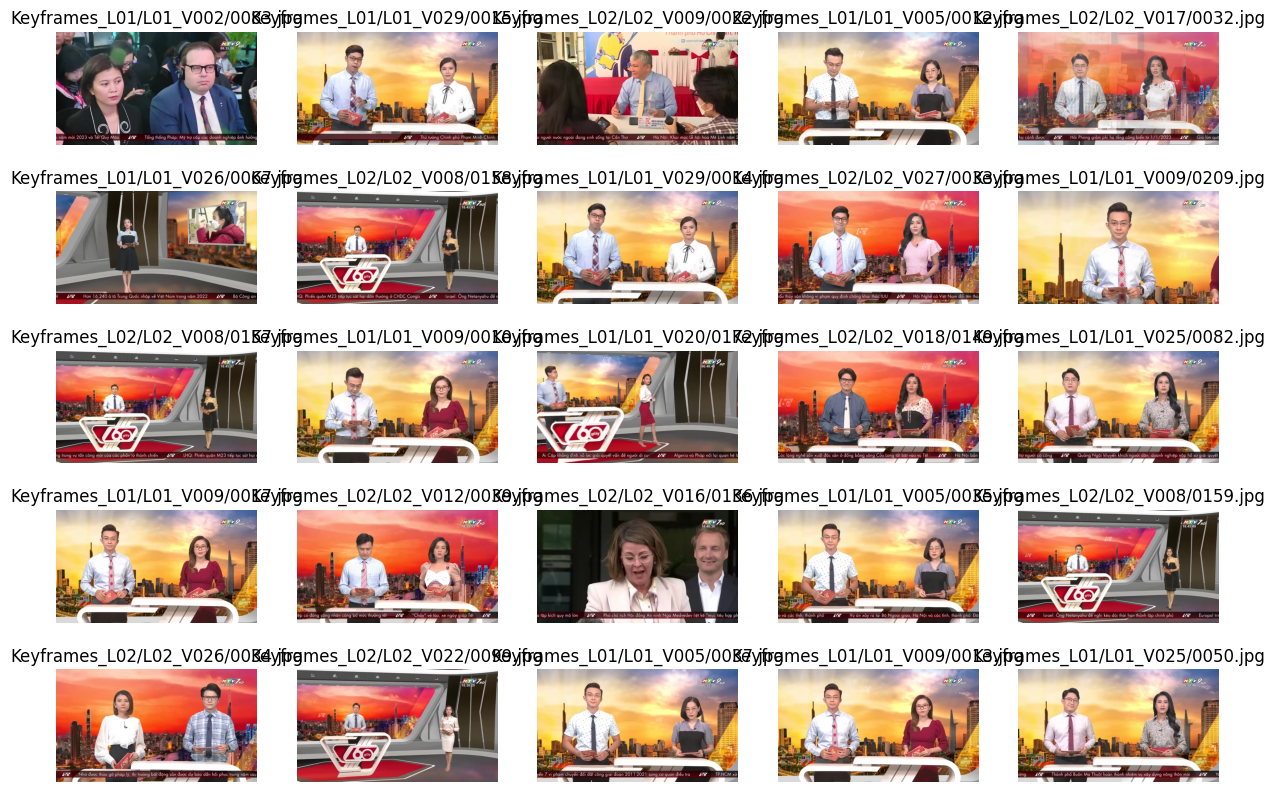

time: 6 s (started: 2023-08-15 02:36:14 +00:00)


In [48]:
##### TESTING #####
bin_file='/content/drive/MyDrive/AIC_2023/Faiss/file/faiss_L2.bin'
json_path = '/content/drive/MyDrive/AIC_2023/Faiss/file/keyframes_id.json'

cosine_faiss = MyFaiss('/content/drive/MyDrive/AIC_2023/Faiss/keyframes', bin_file, json_path)


##### TEXT SEARCH #####
text = 'Có hai người dẫn chương trình, một người là nam mặc áo sơ mi trắng đeo cà vạt, người còn lại là nữ mặc váy. Cả hai người đều đeo kính'

scores, idx_image, image_paths = cosine_faiss.text_search(text, k=25)
cosine_faiss.show_images(image_paths)